In [3]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli, morris
from SALib.analyze import sobol, morris as morris_analyze

## Toggle switch

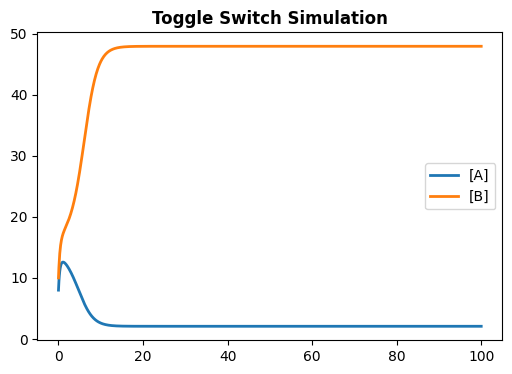

In [ ]:
# ============================================================
# Load model
# ============================================================

antimony_str = """
model toggle_switch()
  species A, B;

  k1 = 50;
  k2 = 50;
  dA = 1;
  dB = 1;
  K  = 10;
  n  = 2;

  J1: -> A; k1 / (1 + (B/K)^n);
  J2: -> B; k2 / (1 + (A/K)^n);
  J3: A -> ; dA*A;
  J4: B -> ; dB*B;

end
"""

model = te.loada(antimony_str)

def new_model():
    return te.loada(antimony_str)

# ============================================================
# INITIAL CONDITIONS & SIMULATION
# ============================================================

model.reset()
model.A = 8
model.B = 10

result = model.simulate(0, 100, 1000)
model.plot(result, title="Toggle Switch Simulation")

In [ ]:
# ============================================================
# LOCAL SENSITIVITY ANALYSIS
# ============================================================

def steady_state_A(m):
    """Compute steady-state value of A."""
    m.steadyState()
    return m.A

params = ["k1", "k2", "dA", "dB", "K", "n"]
sens_local = {}

print("\n=== LOCAL SENSITIVITY ANALYSIS ===\n")

baseline_model = new_model()
baseline_model.A = 8
baseline_model.B = 10
baseline = steady_state_A(baseline_model)

print(f"Baseline steady-state A = {baseline}")

for p in params:
    m = new_model()

    m.A = 8
    m.B = 10

    value = m.getValue(p)
    delta = 0.01 * value if value != 0 else 0.01

    m.setValue(p, value + delta)
    perturbed = steady_state_A(m)

    sensitivity = (perturbed - baseline) / delta
    sens_local[p] = sensitivity

    print(f"Sensitivity dAss/d{p} = {sensitivity}")


=== LOCAL SENSITIVITY ANALYSIS ===

Baseline steady-state A = 15.159802276925792
Sensitivity dAss/dk1 = -0.317748070287621
Sensitivity dAss/dk2 = 0.44698993331475023
Sensitivity dAss/ddA = 16.13980380034903
Sensitivity dAss/ddB = -22.279964226024696
Sensitivity dAss/dK = 0.880333555392081
Sensitivity dAss/dn = -1.8237262409949828


In [ ]:
# ============================================================
# GLOBAL SENSITIVITY (SOBOL)
# ============================================================

print("\n=== GLOBAL SENSITIVITY ANALYSIS ===\n")

problem = {
    "num_vars": 6,
    "names": ["k1", "k2", "dA", "dB", "K", "n"],
    "bounds": [
        [10, 100],
        [10, 100],
        [0.1, 2],
        [0.1, 2],
        [1, 50],
        [1, 4],
    ]
}

def evaluate(params):
    m = new_model()
    m.A = 8
    m.B = 10
    m.k1, m.k2, m.dA, m.dB, m.K, m.n = params

    try:
        return steady_state_A(m)
    except:
        return 0.0

# ---------------------------
# SOBOL (first-order + total)
# ---------------------------
param_values = saltelli.sample(problem, 512, calc_second_order=False)

Y = np.array([evaluate(p) for p in param_values])

if np.any(np.isnan(Y)):
    finite_mean = np.nanmean(Y)
    Y = np.nan_to_num(Y, nan=finite_mean)

Si = sobol.analyze(
    problem,
    Y,
    calc_second_order=False,  # must match sample()
    print_to_console=True
)

print("\nSobol Sensitivity (S1 and ST):")
for name, s1, st in zip(problem["names"], Si["S1"], Si["ST"]):
    print(f"{name}: S1={s1:.4f}, ST={st:.4f}")



=== GLOBAL SENSITIVITY ANALYSIS ===



C:\Users\grilj\AppData\Local\Temp\ipykernel_38888\2647499074.py:39: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`



          ST   ST_conf
k1  0.758467  0.291653
k2  0.787700  0.273611
dA  1.435781  1.700390
dB  0.723193  0.379843
K   1.321389  0.719519
n   0.678679  0.320264
          S1   S1_conf
k1  0.012751  0.050789
k2  0.005204  0.067917
dA -0.008308  0.091665
dB  0.009679  0.050025
K   0.061691  0.103613
n   0.055089  0.084997

Sobol Sensitivity (S1 and ST):
k1: S1=0.0128, ST=0.7585
k2: S1=0.0052, ST=0.7877
dA: S1=-0.0083, ST=1.4358
dB: S1=0.0097, ST=0.7232
K: S1=0.0617, ST=1.3214
n: S1=0.0551, ST=0.6787


TypeError: 'module' object is not callable

In [ ]:
# from SALib.sample import morris
# from SALib.analyze import morris as morris_analyze

# # ---------------------------
# # MORRIS GLOBAL SENSITIVITY
# # ---------------------------

# # Generate samples
# morris_samples = morris.sample(
#     problem,
#     N=200,
#     num_levels=8
# )

# # Evaluate the model for each Morris sample
# Y_morris = np.array([evaluate(p) for p in morris_samples])

# # Optional: filter NaNs (Morris can handle arbitrary X, Y length)
# valid = ~np.isnan(Y_morris)
# morris_samples = morris_samples[valid]
# Y_morris = Y_morris[valid]

# morris_results = morris_analyze.analyze(
#     problem,
#     morris_samples,
#     Y_morris,
#     print_to_console=True
# )

# print("\n=== Morris μ* (Main Effect) ===")
# for name, mu in zip(problem["names"], morris_results["mu_star"]):
#     print(f"{name}: μ* = {mu:.4f}")

# print("\n=== Morris σ (Nonlinearity / Interaction) ===")
# for name, sig in zip(problem["names"], morris_results["sigma"]):
#     print(f"{name}: σ = {sig:.4f}")


## Oscilator

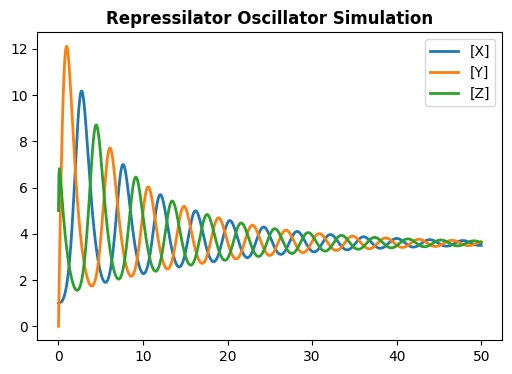

In [ ]:
# ============================================================
# REPRESSILATOR MODEL (Synthetic Oscillator)
# ============================================================

model = te.loada("""
model repressilator()

  // ======================================================
  // Species = Protein concentrations
  // X represses Y
  // Y represses Z
  // Z represses X
  // ======================================================
  species X, Y, Z;

  // ======================================================
  // Parameters
  // k   = maximum production rate
  // d   = degradation rate of proteins
  // K   = repression threshold (affinity)
  // n   = Hill coefficient (cooperativity)
  // ======================================================
  k = 50;
  d = 1;
  K = 1;
  n = 2;

  // ======================================================
  // Reactions:
  // Production is repressed by previous protein in the cycle
  // X' = k / (1 + (Z/K)^n) - d*X
  // Y' = k / (1 + (X/K)^n) - d*Y
  // Z' = k / (1 + (Y/K)^n) - d*Z
  // ======================================================

  J1: -> X; k / (1 + (Z/K)^n);
  J2: -> Y; k / (1 + (X/K)^n);
  J3: -> Z; k / (1 + (Y/K)^n);

  // Degradation
  J4: X -> ; d * X;
  J5: Y -> ; d * Y;
  J6: Z -> ; d * Z;

end
""")

def new_model_repressilator():
    return te.loada(model.getAntimony())
# ============================================================
# Initial conditions
# Oscillations often require asymmetric start
# ============================================================

model.X = 1
model.Y = 0
model.Z = 5

# ============================================================
# Simulation
# ============================================================

result = model.simulate(0, 50, 1000)
model.plot(result, title="Repressilator Oscillator Simulation")


In [ ]:
# ============================================================
# LOCAL SENSITIVITY ANALYSIS FOR REPRESSILATOR
# ============================================================

def oscillation_amplitude(m):
    """
    Compute amplitude of oscillation for X.
    We simulate long enough for oscillations to appear.
    """
    result = m.simulate(0, 200, 2000)  
    X = result[:, 1]  
    return np.max(X) - np.min(X)


params = ["k", "d", "K", "n"]   # repressilator parameters
sens_local_osc = {}

print("\n=== LOCAL SENSITIVITY ANALYSIS (OSCILLATOR) ===\n")

# Baseline model
baseline_model = new_model_repressilator()   
baseline_model.X = 1
baseline_model.Y = 0
baseline_model.Z = 5

baseline = oscillation_amplitude(baseline_model)

print(f"Baseline oscillation amplitude (X) = {baseline}")

# Sensitivity calculation
for p in params:
    m = new_model_repressilator()

    m.X = 1
    m.Y = 0
    m.Z = 5

    value = m.getValue(p)
    delta = 0.01 * value if value != 0 else 0.01

    m.setValue(p, value + delta)
    perturbed = oscillation_amplitude(m)

    sensitivity = (perturbed - baseline) / delta
    sens_local_osc[p] = sensitivity

    print(f"Sensitivity dAmp/d{p} = {sensitivity}")



=== LOCAL SENSITIVITY ANALYSIS (OSCILLATOR) ===

Baseline oscillation amplitude (X) = 9.173951560261896
Sensitivity dAmp/dk = 0.12066642689909912
Sensitivity dAmp/dd = -5.13154803915441
Sensitivity dAmp/dK = 2.3265820188708375
Sensitivity dAmp/dn = 11.312483626259695


In [ ]:
# ============================================================
# GLOBAL SENSITIVITY (SOBOL) FOR REPRESSILATOR
# ============================================================

print("\n=== GLOBAL SENSITIVITY ANALYSIS (OSCILLATOR - SOBOL) ===\n")

problem_osc = {
    "num_vars": 4,
    "names": ["k", "d", "K", "n"],
    "bounds": [
        [10, 100],   # k
        [0.1,  5],   # d
        [0.5,  10],  # K
        [1,    4],   # n
    ]
}

def evaluate_oscillator(params):
    """
    Sobol evaluation function for oscillator.
    Computes amplitude of X after simulation.
    Much faster and more stable than steady-state.
    """
    m = new_model_repressilator()
    m.X = 1
    m.Y = 0
    m.Z = 5

    m.k, m.d, m.K, m.n = params

    try:
        result = m.simulate(0, 150, 1500)
        X = result[:, 1]
        return np.max(X) - np.min(X)
    except:
        return 0.0  


param_values = saltelli.sample(problem_osc, 512, calc_second_order=False)

# Evaluate model for each sample
Y = np.array([evaluate_oscillator(p) for p in param_values])

if np.any(np.isnan(Y)):
    Y = np.nan_to_num(Y, nan=np.nanmean(Y))


Si = sobol.analyze(problem_osc, Y, calc_second_order=False, print_to_console=True)

print("\nSobol Sensitivity (S1 and ST):")
for name, s1, st in zip(problem_osc["names"], Si["S1"], Si["ST"]):
    print(f"{name}: S1={s1:.4f}, ST={st:.4f}")


=== GLOBAL SENSITIVITY ANALYSIS (OSCILLATOR - SOBOL) ===



C:\Users\grilj\AppData\Local\Temp\ipykernel_70312\3921718015.py:44: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`



         ST   ST_conf
k  0.209019  0.147067
d  1.061959  0.629498
K  0.009727  0.006473
n  0.394642  0.247415
         S1   S1_conf
k  0.010374  0.043818
d  0.455484  0.314044
K  0.012580  0.033588
n  0.073542  0.072204

Sobol Sensitivity (S1 and ST):
k: S1=0.0104, ST=0.2090
d: S1=0.4555, ST=1.0620
K: S1=0.0126, ST=0.0097
n: S1=0.0735, ST=0.3946
